In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gpflow

In [ ]:
## Copy gizmo package file from Google Drive to Colab Instance
!cp -r /content/drive/MyDrive/AC297r/gizmo/ ./gizmo

## Locally install `gizmo`
%cd gizmo
!pip install -e .

# Clone teamBlueConduit and install necessary packages and 
!git clone https://github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null

#MAKE SURE TO RESTART KERNEL!

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import gpflow
from gpflow import set_trainable
from gpflow.config import default_float
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.utilities import print_summary
from typing import Tuple, Optional
import pathlib
gpflow.config.set_default_summary_fmt("notebook")
import tensorflow as tf

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

In [ ]:
!ls '/content/drive/MyDrive/AC297r/Data'

Predictions  Processed	Raw  Tuning


In [ ]:
data_dir = '/content/drive/MyDrive/AC297r/Data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, location, train_pid_all, test_pid_all, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir, 'baseline')

In [ ]:
# Load data
train_size = 'ts_0.1'
resolution = 'res_47'
split = 0

train_pid = train_pid_all[train_size][resolution][split]
test_pid = test_pid_all[train_size][resolution][split]

Xtrain = Xdata.loc[train_pid]
Xtest = Xdata.loc[test_pid]
Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
train_pred = train_pred_all[train_size][resolution][split]
test_pred = test_pred_all[train_size][resolution][split]
pid_lat_lon_train = location.loc[train_pid]
pid_lat_lon_test = location.loc[test_pid]

location['orig_index'] = np.arange(location.shape[0])
train_graph_index = location.loc[train_pid, 'orig_index'].values
test_graph_index = location.loc[test_pid, 'orig_index'].values

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape, train_pid.shape, test_pid.shape, train_graph_index.shape, test_graph_index.shape

((2354, 301),
 (19293, 301),
 (2354,),
 (19293,),
 (2354,),
 (19293,),
 (2354,),
 (19293,))

# GPFLOW

## Note: here we are standardizing the lat/lon coordinates to be centered at the origin

In [ ]:
#list(train_idx['ts_0.1']['res_5'][0])


In [ ]:
train_sizes = [0.1]#, 0.3, 0.4, 0.6, 0.7, 0.9]
splits = [0]#, 1, 2]
resolutions = [22]#[5, 10, 22, 47, 99]

def get_all_data_splits(train_sizes, splits, resolutions, include_time = False):
  # assume scaled
  res = {train_size : {hex_size : {} for hex_size in resolutions} for train_size in train_sizes}

  #for train_size in train_sizes:
  for hex_size in resolutions:
    hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
    #res[train_size] = {}
    #for hex_size in resolutions:
    for train_size in train_sizes:

      #res[train_size][hex_size] = {}
      for s in splits:
        split=s
      
        train_pid = train_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
        test_pid = test_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][split]

        Xtrain = Xdata.loc[train_pid]
        Xtest = Xdata.loc[test_pid]
        Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
        Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
        train_pred = train_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
        test_pred = test_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
        pid_lat_lon_train = location.loc[train_pid]
        pid_lat_lon_test = location.loc[test_pid]
        location['orig_index'] = np.arange(location.shape[0])
        train_index = location.loc[train_pid, 'orig_index'].values
        test_index = location.loc[test_pid, 'orig_index'].values
        # print(pid_lat_lon_train)
        # assert 0==1

        # location['orig_index'] = np.arange(location.shape[0])
        # train_graph_index = location.loc[train_pid, 'orig_index'].values
        # test_graph_index = location.loc[test_pid, 'orig_index'].values

        # data = select_data(Xdata,Ydata, pid, train_idx, test_idx, train_pred_all, test_pred_all, partitions_builder, train_size=train_size, n_hexagons=hex_size, split=s)
        # train_index = data['train_index']
        # test_index = data['test_index']
        # Xtrain = data['Xtrain']
        # Xtest = data['Xtest']
        # Ytrain = data['Ytrain']
        # Ytest = data['Ytest']
        # train_pred = data['train_pred']
        # test_pred = data['test_pred']
        # hexagons = data['hexagons']

        lonlatXtrain = pid_lat_lon_train[['Longitude', 'Latitude']].values#[train_index]
        lonlatXtest = pid_lat_lon_test[['Longitude', 'Latitude']].values#[test_index]
      
        if include_time:
          Xscaled = (lonlatXtrain - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)
          Xtscaled = (lonlatXtest - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)

          X = np.hstack([Xtrain['Year Built'].values.reshape(-1, 1), Xscaled[:,0].reshape(-1, 1), Xscaled[:,1].reshape(-1, 1)])
          Xt = np.hstack([Xtest['Year Built'].values.reshape(-1, 1), Xtscaled[:,0].reshape(-1, 1), Xtscaled[:,1].reshape(-1, 1)])

          data = (X, Ytrain.reshape(-1, 1))
          data_t = (Xt, Ytest.reshape(-1, 1))

        else:
          X = lonlatXtrain
          Xt = lonlatXtest

          data = ((X - X.mean(axis=0))/X.std(axis=0), Ytrain.reshape(-1, 1))
          data_t = ((Xt - X.mean(axis=0))/X.std(axis=0), Ytest.reshape(-1, 1))
        
        res[train_size][hex_size][s] = data, data_t, hexagons, Ytest, test_pred, test_index

  return res

GP_data = get_all_data_splits(train_sizes, splits, resolutions, include_time=True)


2021-11-18 02:10.34 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 21039.59it/s]

2021-11-18 02:10.37 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:10.37 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:10.39 [debug    ] Total parcels after join: 26857
2021-11-18 02:10.39 [info     ] Building the connected graph on the partitions.
2021-11-18 02:10.40 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory


In [ ]:
# setup mesh
def plot_model(fig, ax, model, plot_var = False, X=None, y=None, lead_mask=None, title=None, include_time=False):

  if include_time:
    # do all spatio temporal stuff here
    grid_resolution = 30

    YEAR_MIN, YEAR_MAX, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX = 1900, 2020, -3, 3, -3, 3

    x = np.linspace(YEAR_MIN, YEAR_MAX,grid_resolution)
    y = np.linspace(LON_MIN, LON_MAX,grid_resolution)
    z = np.linspace(LAT_MIN, LAT_MAX,grid_resolution)

    XX, YY, ZZ = np.meshgrid(x, y, z)
    xgrid = np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()]

    mean, cov = model.predict_y(xgrid)
    ygrid_prob = mean.numpy()

    # Creating plot
    ax.scatter3D(XX, YY, ZZ, c=ygrid_prob, cmap=cm.RdYlGn_r, alpha=0.1, marker='.')
    if X is not None and y is not None:
      ax.scatter3D(X[np.logical_not(lead_mask),0], X[np.logical_not(lead_mask),1], X[np.logical_not(lead_mask),2], alpha=0.5, marker='o', color='green')
      ax.scatter3D(X[lead_mask,0], X[lead_mask,1], X[lead_mask,2], alpha=0.5, marker='x', color='red')
    ax.set_xlabel('YEAR')
    ax.set_ylabel('LONGITUDE')
    ax.set_zlabel('LATITUDE')
    ax.set_xlim(YEAR_MIN, YEAR_MAX)
    ax.set_ylim(LON_MIN, LON_MAX)
    ax.set_zlim(LAT_MIN, LAT_MAX)
    if title:
      ax.set_title(title, fontsize=15)

  else:
    LON_MIN, LON_MAX, LAT_MIN, LAT_MAX = -3, 3, -3, 3

    x1v, x2v = np.meshgrid(np.linspace(LON_MIN, LON_MAX,100), np.linspace(LAT_MIN, LAT_MAX,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]

    mean, cov = model.predict_y(xgrid)
    ygrid_prob = mean.numpy().reshape(x1v.shape) 
    ygrid_var = cov.numpy().reshape(x1v.shape) 
    
    if plot_var:

      colormesh_prob = ax[0].pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.8, shading='auto', vmin=0, vmax=1, cmap=cm.RdYlGn_r)
      cb_prob = fig.colorbar(colormesh_prob, ax=ax[0])
      cb_prob.set_label('Probability of lead')
      # decision boundary of 0.5
      cs = ax[0].contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
      ax[0].clabel(cs, fontsize=20)

      colormesh_var = ax[1].pcolormesh(x1v, x2v, ygrid_var,alpha = 0.8, shading='auto', cmap = cm.Blues_r)
      cb_var = fig.colorbar(colormesh_var, ax=ax[1])
      cb_var.set_label('Variance')

    else:
      colormesh_prob = ax.pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.7, shading='auto', vmin=0, vmax=1, cmap=cm.RdYlGn_r)
      cb_prob = fig.colorbar(colormesh_prob, ax=ax)
      cb_prob.set_label('Probability of lead')
      # decision boundary of 0.5
      cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
      ax.clabel(cs, fontsize=20)

    # plot data
    if X is not None and y is not None:
      if plot_var:
        ax[0].scatter(X[np.logical_not(lead_mask), 0], X[np.logical_not(lead_mask), 1], marker='o', color='green', alpha=0.6)
        ax[0].scatter(X[lead_mask, 0], X[lead_mask, 1], marker='x', color='red', alpha=0.6)
      else:
        ax.scatter(X[np.logical_not(lead_mask), 0], X[np.logical_not(lead_mask), 1], marker='o', color='green', alpha=0.6)
        ax.scatter(X[lead_mask, 0], X[lead_mask, 1], marker='x', color='red', alpha=0.6)
    if plot_var:
      ax[0].set_xlabel('Longitude', fontsize=10)
      ax[0].set_ylabel('Latitude', fontsize=10)
      ax[0].set_xlim(LON_MIN, LON_MAX)
      ax[0].set_ylim(LAT_MIN, LAT_MAX)
      ax[0].set_title('Mean')
      ax[1].set_xlabel('Longitude', fontsize=10)
      ax[1].set_ylabel('Latitude', fontsize=10)
      ax[1].set_xlim(LON_MIN, LON_MAX)
      ax[1].set_ylim(LAT_MIN, LAT_MAX)
      ax[1].set_title('Variance')
      if title:
        fig.suptitle(title, fontsize=20)
    else:
      ax.set_xlabel('Longitude', fontsize=10)
      ax.set_ylabel('Latitude', fontsize=10)
      ax.set_xlim(LON_MIN, LON_MAX)
      ax.set_ylim(LAT_MIN, LAT_MAX)
      ax.set_title('Mean')
      if title:
        ax.set_title(title, fontsize=15)

def do_the_plotting(models, X, Y, X_spatiotemp, Y_spatiotemp):
  spatio_svgp, spatiotemp_svgp = models
  m, _ = spatio_svgp.predict_y(X)
  a = accuracy_score(Y, np.round(m.numpy()))

  m_spatiotemp, _ = spatiotemp_svgp.predict_y(X_spatiotemp)
  a_spatiotemp = accuracy_score(Y_spatiotemp, np.round(m_spatiotemp.numpy()))

  fig = plt.figure(figsize=(16,8))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2, projection="3d")
  sample_idx = np.random.choice(np.arange(X_spatiotemp.shape[0]), 1000)
  sampleX = X[sample_idx,:]
  sampleY = Y[sample_idx,:]
  sampleX_spatiotemp = X_spatiotemp[sample_idx,:]
  sampleY_spatiotemp = Y_spatiotemp[sample_idx,:]

  plot_model(fig, ax1, spatio_svgp, X=sampleX, y=sampleY, lead_mask=(sampleY[:,0]==1), title=f'Accuracy: {100*np.round(a,3)}%')
  plot_model(fig, ax2, spatiotemp_svgp, X=sampleX_spatiotemp, y=sampleY_spatiotemp, lead_mask=(sampleY_spatiotemp[:,0]==1), include_time=True, title=f'Accuracy: {100*np.round(a_spatiotemp,3)}%')
  fig.suptitle('Including time as a feature improves GP performance')
  plt.tight_layout()
  plt.show()

In [ ]:
def get_trained_svgp(X, Y, iterations, include_time=False):

    logf = []

    minibatch_size = 1000

    N = X.shape[0]

    kernel = gpflow.kernels.Matern12(variance=50, lengthscales=[10,10])
    if include_time:
      kernel = gpflow.kernels.Matern12(variance=50, lengthscales=[10,10,10])
    # inducing variables
    inducing_idx = np.random.choice(np.arange(X.shape[0]), 500)
    Z = X[inducing_idx,:]
    N = X.shape[0]
    svgp_model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Bernoulli(), Z, num_data=N)


    # We turn off training for inducing point locations
    gpflow.set_trainable(svgp_model.inducing_variable, False)

    train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = svgp_model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=1e-1)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, svgp_model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return svgp_model




In [ ]:

train_size=0.3
hex_size=47
split=0
      
train_pid = train_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
test_pid = test_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][split]

Xtrain = Xdata.loc[train_pid]
Xtest = Xdata.loc[test_pid]
Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
train_pred = train_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
test_pred = test_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
pid_lat_lon_train = location.loc[train_pid]
pid_lat_lon_test = location.loc[test_pid]
location['orig_index'] = np.arange(location.shape[0])
train_index = location.loc[train_pid, 'orig_index'].values
test_index = location.loc[test_pid, 'orig_index'].values

lonlatXtrain = pid_lat_lon_train[['Longitude', 'Latitude']].values
lonlatXtest = pid_lat_lon_test[['Longitude', 'Latitude']].values

X = (lonlatXtrain - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)
Xt = (lonlatXtest - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)

X_spatiotemp = np.hstack([Xtrain['Year Built'].values.reshape(-1, 1), X[:,0].reshape(-1, 1), X[:,1].reshape(-1, 1)])
X_spatiotemp_t = np.hstack([Xtest['Year Built'].values.reshape(-1, 1), Xt[:,0].reshape(-1, 1), Xt[:,1].reshape(-1, 1)])

spatio_svgp1 = get_trained_svgp(X, Ytrain.reshape(-1,1), ci_niter(500))
spatiotemp_svgp1 = get_trained_svgp(X_spatiotemp, Ytrain.reshape(-1,1), ci_niter(500), include_time=True)
models1 = spatio_svgp1, spatiotemp_svgp1


In [ ]:
spatiotemp_svgp1

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,5.327573521832851
SVGP.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[31.16071001 25.64008224 29.27138202]
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(500, 3)",float64,"[[1.95500000e+03, -4.48003016e-01, -1.48460976e+00..."
SVGP.q_mu,Parameter,Identity,,True,"(500, 1)",float64,[[-5.92397357e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 500, 500)",float64,"[[[1.28374298e-01, 0.00000000e+00, 0.00000000e+00..."


In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)

2021-11-18 02:14.25 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 22098.59it/s]

2021-11-18 02:14.28 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:14.28 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:14.30 [debug    ] Total parcels after join: 26857
2021-11-18 02:14.30 [info     ] Building the connected graph on the partitions.
2021-11-18 02:14.33 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


In [ ]:
hexagons.parcel_gdf

,pid,Property Zip Code,Owner Type,Owner State,Homestead,Homestead Percent,HomeSEV,Land Value,Land Improvements Value,Residential Building Value,Residential Building Style,Commercial Building Value,Building Storeys,Parcel Acres,Rental,Use Type,Prop Class,Old Prop class,Year Built,USPS Vacancy,Zoning,Future Landuse,DRAFT Zone,Housing Condition 2012,Housing Condition 2014,Commercial Condition 2013,Latitude,Longitude,Hydrant Type,Ward,PRECINCT,CENTRACT,CENBLOCK,SL_Type,SL_Type2,SL_Lead,Ed_July,Ed_March,Last_Test,Max_Lead,...,Res_Test,Sen_Test,SL_private_inspection,B_median_age_all_women,B_median_age_all_men,B_median_age_all,B_median_age_all_women_white,B_median_age_all_men_white,B_median_age_all_white,B_median_age_all_women_black,B_median_age_all_men_black,B_median_age_all_black,B_total_black_pop,B_total_white_pop,B_married_couples,B_single_women,B_married_couples_white,B_single_women_white,B_married_couples_black,B_single_women_black,B_married_couples_w_children,B_single_mothers_w_children,B_households_w_elderly,B_househod_no_elderly,B_aggregate_income,B_speak_spanish,B_speak_only_english,B_no_english,B_hispanic_household,B_imputed_rent,B_imputed_value,sl_private_type,sl_public_type,dangerous,geometry,parcel_id,has_lead,year_built,parcel_acres,partition_ID
0,4012482018,48503.0,Private,MI,Yes,100.0,18400,932,0,35843,TWO STORY,0.0,0,0.140,No,Residential,RI,RI,2,N,B1,Mixed Residential,MR-1,Good,Good,None,43.019000,-83.696946,T.C.,5,32,2800,2,11,0,0,0.0,0.0,None,-1.0,...,0.0,0.0,None,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1,"POLYGON ((13302343.764 554180.147, 13302392.94...",4012482018,1,2,0.140,312
1,4013226009,48503.0,Private,MI,Yes,100.0,11800,420,0,23227,ONE STORY,0.0,0,0.050,No,Residential,RI,RI,2,N,B1,Mixed Residential,MR-1,Fair,Good,None,43.017650,-83.697217,T.C.,5,40,2800,2,0,0,0,0.0,0.0,None,-1.0,...,0.0,0.0,None,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1,"POLYGON ((13302416.008 553775.193, 13302382.97...",4013226009,1,2,0.050,312
2,4012481022,48503.0,Private,MI,Yes,50.0,4550,781,0,17452,TWO UNIT,0.0,0,0.086,No,Residential,RI,RI,2,N,D2,Mixed Residential,MR-2,Good,Good,None,43.017543,-83.698229,Other,5,40,2800,2,11,0,0,0.0,0.0,JAN2016,0.0,...,1.0,0.0,None,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0,GALVANIZED,LEAD,1,"POLYGON ((13302133.281 553746.175, 13302100.92...",4012481022,1,2,0.086,312
3,4013226025,48503.0,Private,MI,Yes,100.0,12800,510,0,25104,TWO STORY,0.0,0,0.070,No,Residential,RI,RI,1900,None,D2,Mixed Residential,MR-1,None,Vacant Lot,None,43.013583,-83.695357,T.C.,5,40,2800,2,11,0,0,0.0,0.0,JAN2016,4.0,...,1.0,0.0,None,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0,COPPER,LEAD,1,"POLYGON ((13302290.107 553667.639, 13302290.12...",4013226025,1,1900,0.070,312
4,4012481014,48503.0,Private,MI,Yes,100.0,0,598,0,19131,TWO STORY,0.0,0,0.071,Yes,Residential,RI,RI,2,N,B1,Mixed Residential,MR-1,Good,Good,None,43.018324,-83.697418,T.C.,5,40,2800,2,11,0,0,0.0,0.0,None,-1.0,...,0.0,0.0,None,24.5,33.4,29.1,36.5,34.4,34.4,23.5,34.6,23.8,782,448,98,75,7,2,83,73,18,64,79,374,6293700.0,19,805,0,3.0,160.0,0.0,COPPER,LEAD,1,"POLYGON ((13302362.528 554036.171, 13302304.79...",4012481014,1,2,0.071,312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21642,4011126001,48504.0,Private,MI,Yes,100.0,12500,975,0,68696,CAPECOD,0.0,0,0.149,No,Residential,RI,RI,1944,N,A2,Traditional Neighborhood,TN-2,Good,Good,None,43.031842,-83.724047,Dar,6,35,1200,3,0,0,0,

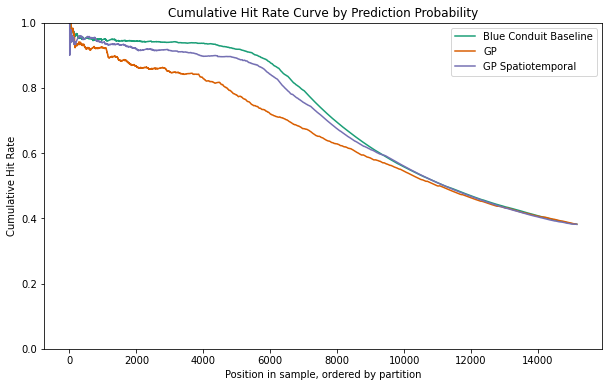

In [ ]:
y_pred_1,_ = spatio_svgp1.predict_y(Xt)

y_pred_1_spatiotemp,_ = spatiotemp_svgp1.predict_y(X_spatiotemp_t)

mod_train_list = [test_pred, y_pred_1.numpy().flatten(), y_pred_1_spatiotemp.numpy().flatten()]

plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'GP', 'GP Spatiotemporal'], mode='partition', 
                    parcel_df=hexagons.parcel_gdf, pid_list=test_pid, threshold_init=0.9)

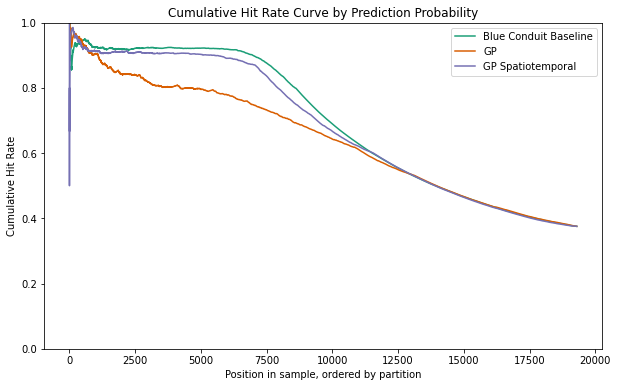

In [ ]:
y_pred_2,_ = spatio_svgp2.predict_y(Xt)

y_pred_2_spatiotemp,_ = spatiotemp_svgp2.predict_y(X_spatiotemp_t2)

mod_train_list = [test_pred2, y_pred_2.numpy().flatten(), y_pred_2_spatiotemp.numpy().flatten()]

plot_hit_rate_curve(Ytest2, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'GP', 'GP Spatiotemporal'], mode='partition', 
                    parcel_df=hexagons2.parcel_gdf, index_list=test_index2, threshold_init=0.9)

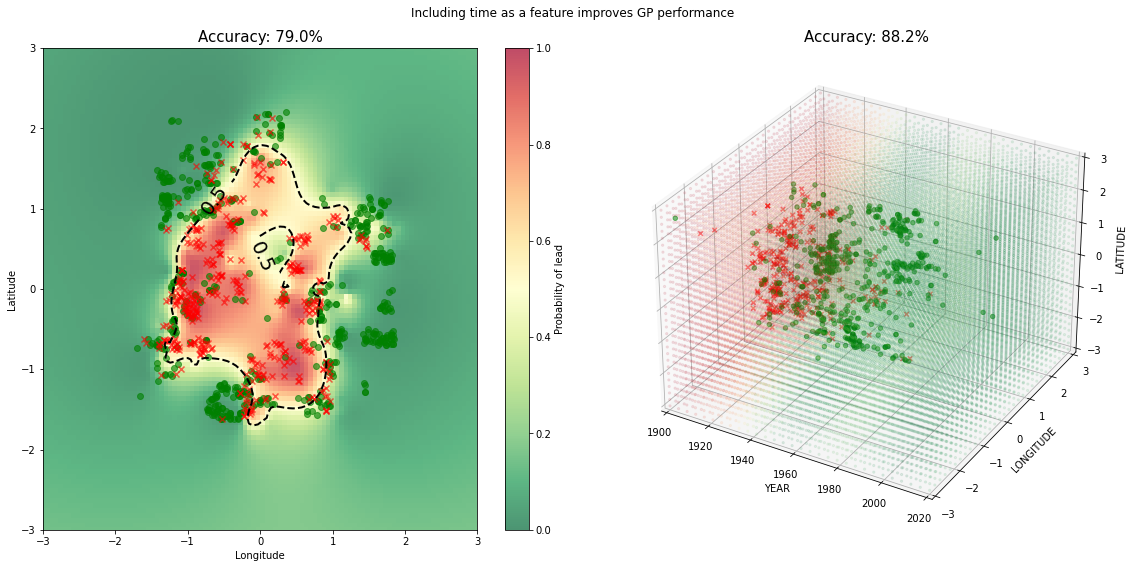

In [ ]:
do_the_plotting(models1, X, Ytrain.reshape(-1,1), X_spatiotemp, Ytrain.reshape(-1,1))


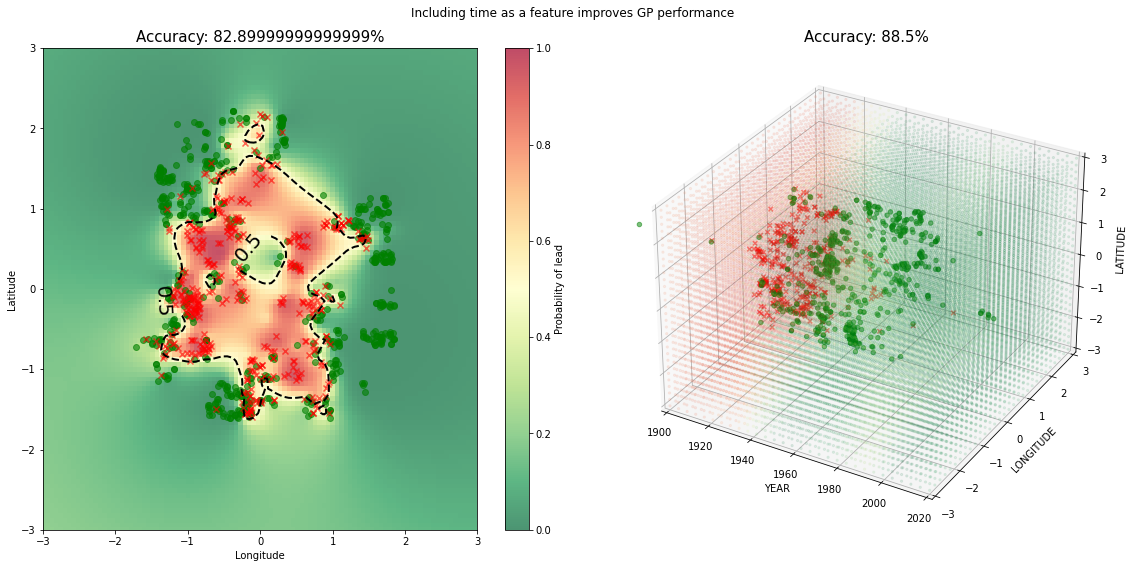

In [ ]:
do_the_plotting(models2, X, Ytrain.reshape(-1,1), X_spatiotemp, Ytrain.reshape(-1,1))

In [ ]:
def train_and_upload_all_model_predictions(GP_data):

  # decided on spatiotemporal model

  train_sizes = [0.1, 0.3, 0.4, 0.6, 0.7, 0.9]
  resolutions = [5, 10, 22, 47, 99]

  GP_spatiotemporal_pred_probs_train = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
  GP_spatiotemporal_pred_probs_test = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
  GP_spatiotemporal_var_pred_probs_train = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
  GP_spatiotemporal_var_pred_probs_test = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

  #for train_size in train_sizes:
  #  for hex_size in resolutions:
  for hex_size in resolutions:
    hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
    for train_size in train_sizes:
      train_preds = []
      test_preds = []
      train_vars = []
      test_vars = []
      accs = []
      for s in [0,1,2]:
        split=s
        print('data split', train_size, hex_size, s)
        #(xtrain, ytrain), (xtest, ytest), _, _, _, _ = GP_data[train_size][hex_size][s]

        train_pid = train_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
        test_pid = test_pid_all[f'ts_{train_size}'][f'res_{hex_size}'][split]

        Xtrain = Xdata.loc[train_pid]
        Xtest = Xdata.loc[test_pid]
        Ytrain = Ydata.loc[train_pid]['dangerous'].values.astype('float')
        Ytest = Ydata.loc[test_pid]['dangerous'].values.astype('float')
        train_pred = train_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
        test_pred = test_pred_all[f'ts_{train_size}'][f'res_{hex_size}'][split]
        pid_lat_lon_train = location.loc[train_pid]
        pid_lat_lon_test = location.loc[test_pid]
        location['orig_index'] = np.arange(location.shape[0])
        train_index = location.loc[train_pid, 'orig_index'].values
        test_index = location.loc[test_pid, 'orig_index'].values

        lonlatXtrain = pid_lat_lon_train[['Longitude', 'Latitude']].values
        lonlatXtest = pid_lat_lon_test[['Longitude', 'Latitude']].values

        X = (lonlatXtrain - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)
        Xt = (lonlatXtest - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)

        X_spatiotemp = np.hstack([Xtrain['Year Built'].values.reshape(-1, 1), X[:,0].reshape(-1, 1), X[:,1].reshape(-1, 1)])
        X_spatiotemp_t = np.hstack([Xtest['Year Built'].values.reshape(-1, 1), Xt[:,0].reshape(-1, 1), Xt[:,1].reshape(-1, 1)])





        #Xscaled = (lonlatXtrain - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)
        #Xtscaled = (lonlatXtest - lonlatXtrain.mean(axis=0))/lonlatXtrain.std(axis=0)

        #X = np.hstack([Xtrain['Year Built'].values.reshape(-1, 1), Xscaled[:,0].reshape(-1, 1), Xscaled[:,1].reshape(-1, 1)])
        #Xt = np.hstack([Xtest['Year Built'].values.reshape(-1, 1), Xtscaled[:,0].reshape(-1, 1), Xtscaled[:,1].reshape(-1, 1)])

        #data = (X, Ytrain.reshape(-1, 1))
        #data_t = (Xt, Ytest.reshape(-1, 1))



        svgp_model = get_trained_svgp(X_spatiotemp, Ytrain.reshape(-1, 1), ci_niter(500), include_time=True)

        y_pred_train, var_train = svgp_model.predict_y(X_spatiotemp)
        y_pred_test, var_test = svgp_model.predict_y(X_spatiotemp_t)

        train_preds.append(y_pred_train.numpy().flatten())
        test_preds.append(y_pred_test.numpy().flatten())
        train_vars.append(var_train.numpy().flatten())
        test_vars.append(var_test.numpy().flatten())
        accs.append(accuracy_score(Ytest.reshape(-1, 1), np.round(y_pred_test.numpy().flatten())))
      print('test acc: ', sum(accs)/3, '(', accs[0], ',',accs[1], ',', accs[2], ')')
      
      GP_spatiotemporal_pred_probs_train[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(train_preds)
      GP_spatiotemporal_pred_probs_test[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(test_preds)
      GP_spatiotemporal_var_pred_probs_train[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(train_vars)
      GP_spatiotemporal_var_pred_probs_test[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(test_vars)

  np.savez(f'{pred_dir}/GP_spatiotemporal_pred_probs_train.npz', **GP_spatiotemporal_pred_probs_train)
  np.savez(f'{pred_dir}/GP_spatiotemporal_pred_probs_test.npz', **GP_spatiotemporal_pred_probs_test)
  np.savez(f'{pred_dir}/GP_spatiotemporal_var_pred_probs_train.npz', **GP_spatiotemporal_var_pred_probs_train)
  np.savez(f'{pred_dir}/GP_spatiotemporal_var_pred_probs_test.npz', **GP_spatiotemporal_var_pred_probs_test)

train_and_upload_all_model_predictions(GP_data)


2021-11-18 02:25.54 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 33/33 [00:00<00:00, 10216.42it/s]

2021-11-18 02:25.57 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:25.57 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:25.59 [debug    ] Total parcels after join: 26857
2021-11-18 02:25.59 [info     ] Building the connected graph on the partitions.
2021-11-18 02:25.59 [info     ] New Partition dataframe of type 'hexagon' created, using at least 17.37 MB of memory
data split 0.1 5 0
data split 0.1 5 1
data split 0.1 5 2
test acc:  0.7896433829071466 ( 0.8096919261967805 , 0.6953943217665615 , 0.8638439007580979 )
data split 0.3 5 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.3 5 1
data split 0.3 5 2
test acc:  0.8569487168798352 ( 0.8032931490738018 , 0.8886451830605703 , 0.8789078185051339 )
data split 0.4 5 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.4 5 1
data split 0.4 5 2
test acc:  0.8793420629617578 ( 0.8667476193519524 , 0.8906203709190021 , 0.8806581986143187 )
data split 0.6 5 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.6 5 1
data split 0.6 5 2
test acc:  0.8744449245716472 ( 0.8721712538226299 , 0.9006216776286152 , 0.8505418422636966 )
data split 0.7 5 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.7 5 1
data split 0.7 5 2
test acc:  0.8664596331953206 ( 0.8552960800667223 , 0.893370329997027 , 0.8507124895222129 )
data split 0.9 5 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.9 5 1
data split 0.9 5 2
test acc:  0.908240193651855 ( 0.8785658204658466 , 0.9418994413407821 , 0.9042553191489362 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

2021-11-18 02:27.39 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 77/77 [00:00<00:00, 14704.13it/s]

2021-11-18 02:27.41 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:27.41 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:27.43 [debug    ] Total parcels after join: 26857
2021-11-18 02:27.44 [info     ] Building the connected graph on the partitions.
2021-11-18 02:27.44 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.99 MB of memory
data split 0.1 10 0
data split 0.1 10 1
data split 0.1 10 2
test acc:  0.85707063848348 ( 0.8811342742457594 , 0.8155489713308016 , 0.8745286698738786 )
data split 0.3 10 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.3 10 1
data split 0.3 10 2
test acc:  0.8666867343550009 ( 0.875998866534429 , 0.8258811422691021 , 0.8981801942614714 )
data split 0.4 10 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.4 10 1
data split 0.4 10 2
test acc:  0.8850027464772489 ( 0.8894048961719632 , 0.872899480598839 , 0.8927038626609443 )
data split 0.6 10 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.6 10 1
data split 0.6 10 2
test acc:  0.8815362664705771 ( 0.8975395114942529 , 0.8634402698250844 , 0.8836290180923941 )
data split 0.7 10 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.7 10 1
data split 0.7 10 2
test acc:  0.8744424109311589 ( 0.9030138700594431 , 0.8501350135013501 , 0.8701783492326836 )
data split 0.9 10 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.9 10 1
data split 0.9 10 2
test acc:  0.8645625359033687 ( 0.9058854718981972 , 0.794480755265069 , 0.89332138054684 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

2021-11-18 02:29.23 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 289/289 [00:00<00:00, 20197.85it/s]

2021-11-18 02:29.26 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:29.26 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:29.28 [debug    ] Total parcels after join: 26857
2021-11-18 02:29.28 [info     ] Building the connected graph on the partitions.
2021-11-18 02:29.29 [info     ] New Partition dataframe of type 'hexagon' created, using at least 16.16 MB of memory
data split 0.1 22 0
data split 0.1 22 1
data split 0.1 22 2
test acc:  0.8656551385976612 ( 0.87071992976295 , 0.8824714573539288 , 0.8437740286761047 )
data split 0.3 22 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.3 22 1
data split 0.3 22 2
test acc:  0.8869794457377084 ( 0.8886359756444545 , 0.8846335418387821 , 0.8876688197298884 )
data split 0.4 22 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.4 22 1
data split 0.4 22 2
test acc:  0.8890971257883092 ( 0.8816793893129771 , 0.8825230314034026 , 0.9030889566485483 )
data split 0.6 22 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.6 22 1
data split 0.6 22 2
test acc:  0.8929607537565367 ( 0.8928972917731222 , 0.8894131524624005 , 0.8965718170340876 )
data split 0.7 22 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.7 22 1
data split 0.7 22 2
test acc:  0.8962470579543007 ( 0.8938026474127557 , 0.898272320889211 , 0.8966662055609351 )
data split 0.9 22 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.9 22 1
data split 0.9 22 2
test acc:  0.9002197281253864 ( 0.8779467680608365 , 0.8907597535934292 , 0.9319526627218935 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

2021-11-18 02:31.08 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 24216.00it/s]

2021-11-18 02:31.10 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:31.10 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:31.13 [debug    ] Total parcels after join: 26857
2021-11-18 02:31.13 [info     ] Building the connected graph on the partitions.
2021-11-18 02:31.16 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
data split 0.1 47 0
data split 0.1 47 1
data split 0.1 47 2
test acc:  0.8813325594463656 ( 0.8802156222464106 , 0.8823923001698492 , 0.8813897559228369 )
data split 0.3 47 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.3 47 1
data split 0.3 47 2
test acc:  0.8876218386936786 ( 0.8916155419222904 , 0.8886506766715798 , 0.8825992974871656 )
data split 0.4 47 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.4 47 1
data split 0.4 47 2
test acc:  0.8915954182522517 ( 0.8945578231292517 , 0.8914090414789498 , 0.8888193901485536 )
data split 0.6 47 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.6 47 1
data split 0.6 47 2
test acc:  0.897476410636016 ( 0.909070447895566 , 0.8954882924043404 , 0.8878704916081419 )
data split 0.7 47 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.7 47 1
data split 0.7 47 2
test acc:  0.8968796533224928 ( 0.9125424730388536 , 0.8877165354330708 , 0.8903799514955537 )
data split 0.9 47 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.9 47 1
data split 0.9 47 2
test acc:  0.9045876153422016 ( 0.9228014325507362 , 0.9031302876480541 , 0.8878311258278145 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

2021-11-18 02:32.56 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 4828/4828 [00:00<00:00, 22365.82it/s]

2021-11-18 02:32.58 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-18 02:32.58 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-18 02:33.01 [debug    ] Total parcels after join: 26857
2021-11-18 02:33.01 [info     ] Building the connected graph on the partitions.
2021-11-18 02:33.20 [info     ] New Partition dataframe of type 'hexagon' created, using at least 10.95 MB of memory
data split 0.1 99 0
data split 0.1 99 1
data split 0.1 99 2
test acc:  0.8895353168811203 ( 0.8917812814491781 , 0.8897541816211824 , 0.8870704875730001 )
data split 0.3 99 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.3 99 1
data split 0.3 99 2
test acc:  0.8976960733902435 ( 0.8969924171423703 , 0.8982369051694625 , 0.8978588978588978 )
data split 0.4 99 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.4 99 1
data split 0.4 99 2
test acc:  0.8968109128476588 ( 0.8960181352257047 , 0.8944551055448945 , 0.8999594977723775 )
data split 0.6 99 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.6 99 1
data split 0.6 99 2
test acc:  0.8990703269233208 ( 0.9050295857988165 , 0.896690518783542 , 0.8954908761876037 )
data split 0.7 99 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.7 99 1
data split 0.7 99 2
test acc:  0.9030265771453717 ( 0.907671286355651 , 0.8968949044585988 , 0.9045135406218656 )
data split 0.9 99 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

data split 0.9 99 1
data split 0.9 99 2
test acc:  0.9054408205306176 ( 0.9087389380530974 , 0.9014749262536873 , 0.9061085972850679 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lo

In [ ]:
GP_spatiotemporal_results = pd.DataFrame(
    [[.868, .870, .881, .893, .886],
    [.879, .885, .892, .892, .887],
    [.885, .885, .895, .893, .889],
    [.885, .887, .900, .893, 	.890],
    [.887, .888, .897, .890, .890],
    [.886, .880, .901, .894, .887]], columns = ['5', '10', '22', '47', '99'], index = [0.1, 0.3, 0.4, 0.6, 0.7, 0.9]
)

GP_spatiotemporal_results

,5,10,22,47,99
0.1,0.868,0.870,0.881,0.893,0.886
0.3,0.879,0.885,0.892,0.892,0.887
0.4,0.885,0.885,0.895,0.893,0.889
0.6,0.885,0.887,0.900,0.893,0.890
0.7,0.887,0.888,0.897,0.890,0.890
0.9,0.886,0.880,0.901,0.894,0.887


In [ ]:
GP_spatiotemporal_results.values

array([[0.868, 0.87 , 0.881, 0.893, 0.886],
       [0.879, 0.885, 0.892, 0.892, 0.887],
       [0.885, 0.885, 0.895, 0.893, 0.889],
       [0.885, 0.887, 0.9  , 0.893, 0.89 ],
       [0.887, 0.888, 0.897, 0.89 , 0.89 ],
       [0.886, 0.88 , 0.901, 0.894, 0.887]])

In [ ]:
hist

array([[ 6.,  5.,  6.,  6.],
       [ 6., 10., 12.,  6.],
       [ 4.,  5.,  4.,  3.],
       [ 7.,  6.,  5.,  9.]])

In [ ]:
xedges

array([0., 1., 2., 3., 4., 5.])

In [ ]:
GP_spatiotemporal_results.values.ravel()

array([0.868, 0.87 , 0.881, 0.893, 0.886, 0.879, 0.885, 0.892, 0.892,
       0.887, 0.885, 0.885, 0.895, 0.893, 0.889, 0.885, 0.887, 0.9  ,
       0.893, 0.89 , 0.887, 0.888, 0.897, 0.89 , 0.89 , 0.886, 0.88 ,
       0.901, 0.894, 0.887])

In [ ]:
hist

array([[4., 4., 4., 2., 3., 4.],
       [2., 5., 1., 0., 4., 5.],
       [3., 4., 3., 2., 3., 3.],
       [2., 2., 6., 1., 3., 0.],
       [3., 1., 0., 1., 6., 2.],
       [5., 2., 4., 3., 2., 1.]])

In [ ]:
hist.dtype

dtype('float64')

In [ ]:
GP_spatiotemporal_results.values.dtype

dtype('float64')

In [ ]:
GP_spatiotemporal_results.values

array([[0.868, 0.87 , 0.881, 0.893, 0.886],
       [0.879, 0.885, 0.892, 0.892, 0.887],
       [0.885, 0.885, 0.895, 0.893, 0.889],
       [0.885, 0.887, 0.9  , 0.893, 0.89 ],
       [0.887, 0.888, 0.897, 0.89 , 0.89 ],
       [0.886, 0.88 , 0.901, 0.894, 0.887]])

In [ ]:
np.append(GP_spatiotemporal_results.values, np.arange(6).astype(float)).reshape(6,6)

array([[0.868, 0.87 , 0.881, 0.893, 0.886, 0.879],
       [0.885, 0.892, 0.892, 0.887, 0.885, 0.885],
       [0.895, 0.893, 0.889, 0.885, 0.887, 0.9  ],
       [0.893, 0.89 , 0.887, 0.888, 0.897, 0.89 ],
       [0.89 , 0.886, 0.88 , 0.901, 0.894, 0.887],
       [0.   , 1.   , 2.   , 3.   , 4.   , 5.   ]])

In [ ]:
ypos

array([0.25      , 0.91666667, 1.58333333, 2.25      , 2.91666667,
       3.58333333, 0.25      , 0.91666667, 1.58333333, 2.25      ,
       2.91666667, 3.58333333, 0.25      , 0.91666667, 1.58333333,
       2.25      , 2.91666667, 3.58333333, 0.25      , 0.91666667,
       1.58333333, 2.25      , 2.91666667, 3.58333333, 0.25      ,
       0.91666667, 1.58333333, 2.25      , 2.91666667, 3.58333333,
       0.25      , 0.91666667, 1.58333333, 2.25      , 2.91666667,
       3.58333333])

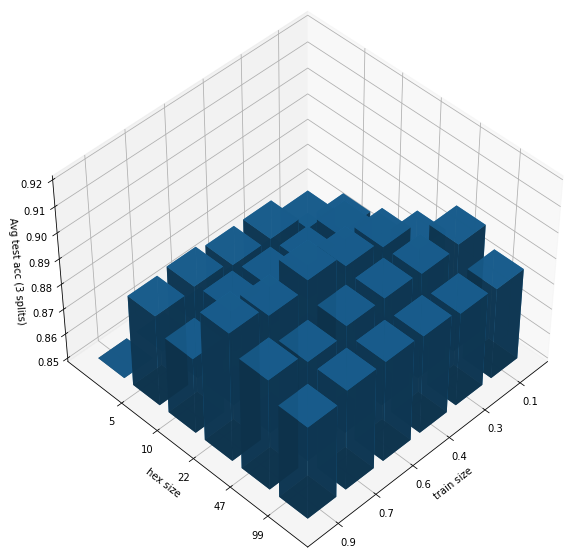

In [ ]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
x, y = np.random.rand(2, 100) * 4
_, xedges, yedges = np.histogram2d(x, y, bins=6, range=[[0, 4], [0, 4]])

# hist = GP_spatiotemporal_results.values
hist[:,0] = 0.85*np.ones(6)
hist[:,[1,2,3,4,5]] = GP_spatiotemporal_results.values

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + .25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0.85

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel() - 0.85

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', alpha=0.9)
ax.set_zlim([0.85, 0.92])
ax.set_xlabel('train size')
ax.set_ylabel('hex size')
ax.set_zlabel('Avg test acc (3 splits)')
ax.set_xticks(xpos[::6]+0.25)
ax.set_yticks(ypos[:5]+0.75)
ax.set_xticklabels(train_sizes)
ax.set_yticklabels(resolutions)
ax.view_init(45, 45)

plt.show()

array([0.25      , 0.91666667, 1.58333333, 2.25      , 2.91666667,
       3.58333333])

In [ ]:

# compare_space_and_time(train_size, hex_size, s)

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
m, v = spatiotemp_svgp.predict_y(X_spatiotemp_t)
accuracy_score(Ytest, np.round(m.numpy()))

0.8940548385424766

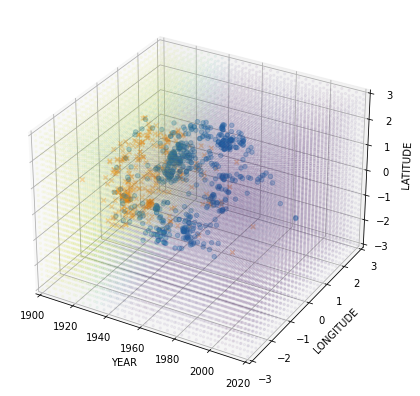

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")
sample_idx = np.random.choice(np.arange(X_spatiotemp_t.shape[0]), 1000)
sampleX = X_spatiotemp_t[sample_idx,:]
sampleY = Y_spatiotemp_t[sample_idx,:]
plot_model(fig, ax, spatiotemp_svgp, X=sampleX, y=sampleY, lead_mask=(sampleY[:,0]==1), include_time=True)
plt.show()

In [ ]:
X_spatio

array([[ 0.17038895,  0.25526239, -0.27223017],
       [-3.80017025, -0.16147155, -0.08051982],
       [-3.80017025, -0.27940804, -0.03887343],
       ...,
       [ 0.30441626, -1.26212882,  1.91812156],
       [ 0.29603956, -1.20848818,  1.97735959],
       [ 0.29603956, -1.21439039,  1.88405113]])

In [ ]:
(X_spatio, Y_spatio)

(array([[ 0.17038895,  0.25526239, -0.27223017],
        [-3.80017025, -0.16147155, -0.08051982],
        [-3.80017025, -0.27940804, -0.03887343],
        ...,
        [ 0.30441626, -1.26212882,  1.91812156],
        [ 0.29603956, -1.20848818,  1.97735959],
        [ 0.29603956, -1.21439039,  1.88405113]]), array([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]]))

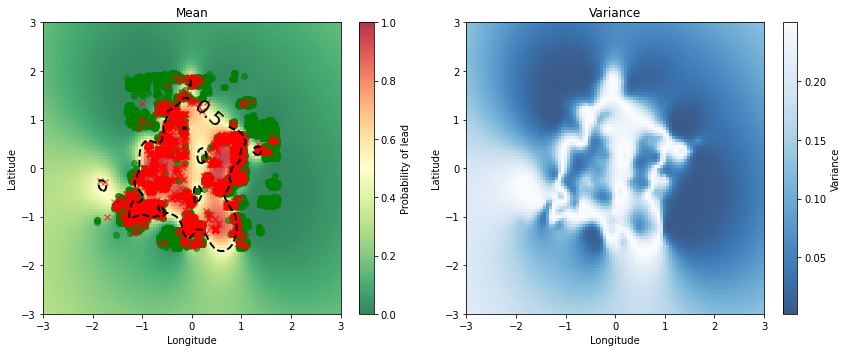

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_model(fig, axes, test_vgp_model, X=test_xtrain, y=test_ytrain, lead_mask = (test_ytrain[:, 0] == 1), plot_var=True)
plt.tight_layout()
plt.show()

In [ ]:
diffusion_train_preds, diffusion_test_preds = load_predictions(pred_dir, probs_prefix='diffusion')

In [ ]:
test_GP_train_preds, test_GP_test_preds = load_predictions(pred_dir, probs_prefix='GP')

In [ ]:
diffusion_train_preds['ts_0.1']['res_10'][0].shape

(2416,)

In [ ]:
test_GP_train_preds['ts_0.1']['res_10'][0].shape

(2416,)

In [ ]:
# trained_models

In [ ]:
def prepare_GP_model_predictions(trained_models):
  GP_train_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
  GP_test_preds = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
  GP_train_vars = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}
  GP_test_vars = {f'ts_{t}' : {f'res_{r}' : [] for r in resolutions} for t in train_sizes}

  for train_size in train_sizes:

    for hex_size in resolutions:
      train_preds = []
      test_preds = []
      train_vars = []
      test_vars = []
      for s in splits:
        print('data split', train_size, s, hex_size)
        (xtrain, _), (xtest, _), _, _, _, _ = GP_data[train_size][s][hex_size]

        model = trained_models[train_size][s][hex_size]

        y_pred_train, var_train = model.predict_y(xtrain)
        y_pred_test, var_test = model.predict_y(xtest)

        train_preds.append(y_pred_train.numpy().flatten())
        test_preds.append(y_pred_test.numpy().flatten())
        train_vars.append(var_train.numpy().flatten())
        test_vars.append(var_test.numpy().flatten())
      
      GP_train_preds[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(train_preds)
      GP_test_preds[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(test_preds)
      GP_train_vars[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(train_vars)
      GP_test_vars[f'ts_{train_size}'][f'res_{hex_size}'] = np.array(test_vars)
  
  return GP_train_preds, GP_test_preds, GP_train_vars, GP_test_vars
def save_GP_model_predictions(GP_results):
  GP_train_preds, GP_test_preds, GP_train_vars, GP_test_vars = GP_results
  np.savez(f'{pred_dir}/GP_pred_probs_train.npz', **GP_train_preds)
  np.savez(f'{pred_dir}/GP_pred_probs_test.npz', **GP_test_preds)
  np.savez(f'{pred_dir}/GP_pred_var_train.npz', **GP_train_vars)
  np.savez(f'{pred_dir}/GP_pred_var_test.npz', **GP_test_vars)
GP_train_preds, GP_test_preds, GP_train_vars, GP_test_vars = prepare_GP_model_predictions(trained_models)
save_GP_model_predictions((GP_train_preds, GP_test_preds, GP_train_vars, GP_test_vars))

data split 0.1 0 5
data split 0.1 1 5
data split 0.1 2 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

data split 0.1 0 10
data split 0.1 1 10
data split 0.1 2 10
data split 0.1 0 22
data split 0.1 1 22
data split 0.1 2 22
data split 0.1 0 47
data split 0.1 1 47
data split 0.1 2 47
data split 0.1 0 99
data split 0.1 1 99
data split 0.1 2 99
data split 0.3 0 5
data split 0.3 1 5
data split 0.3 2 5
data split 0.3 0 10
data split 0.3 1 10
data split 0.3 2 10
data split 0.3 0 22
data split 0.3 1 22
data split 0.3 2 22
data split 0.3 0 47
data split 0.3 1 47
data split 0.3 2 47
data split 0.3 0 99
data split 0.3 1 99
data split 0.3 2 99
data split 0.4 0 5
data split 0.4 1 5
data split 0.4 2 5
data split 0.4 0 10
data split 0.4 1 10
data split 0.4 2 10
data split 0.4 0 22
data split 0.4 1 22
data split 0.4 2 22
data split 0.4 0 47
data split 0.4 1 47
data split 0.4 2 47
data split 0.4 0 99
data split 0.4 1 99
data split 0.4 2 99
data split 0.6 0 5
data split 0.6 1 5
data split 0.6 2 5
data split 0.6 0 10
data split 0.6 1 10
data split 0.6 2 10
data split 0.6 0 22
data split 0.6 1 22
data spli

In [ ]:

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# plot_model(fig, axes, svgp_model, X=test_xtrain, y=test_ytrain, lead_mask = (test_ytrain[:, 0] == 1), plot_var=True)
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


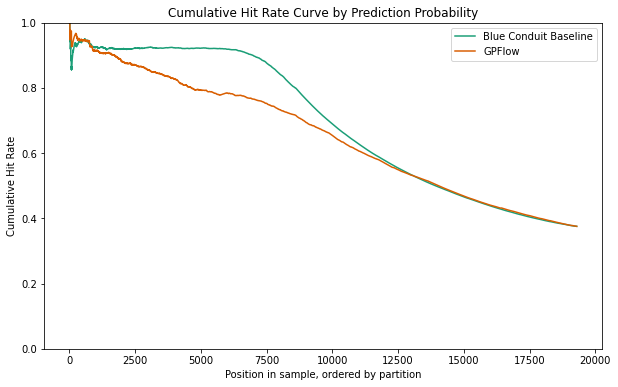

In [ ]:
def plot_hit_rate_curve_by_split_num(split_num = 0):
  (xtrain, ytrain), (xtest, ytest), hex, Ytest, test_pred, test_index = GP_data[split_num]
  vgp_test_pred, vgp_test_var = models[split_num].predict_y(xtest)
  mod_train_list = [test_pred, vgp_test_pred.numpy().flatten()]

  plot_hit_rate_curve(Ytest, mod_train_list, plot_probs=False, labels=['Blue Conduit Baseline', 'GPFlow'], mode='partition', 
                      parcel_df=hex.parcel_gdf, index_list=test_index, threshold_init=0.9)
# plot_hit_rate_curve_by_split_num()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


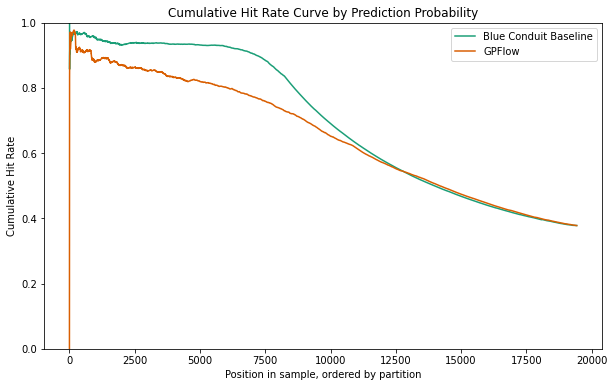

In [ ]:
# plot_hit_rate_curve_by_split_num(split_num=1)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


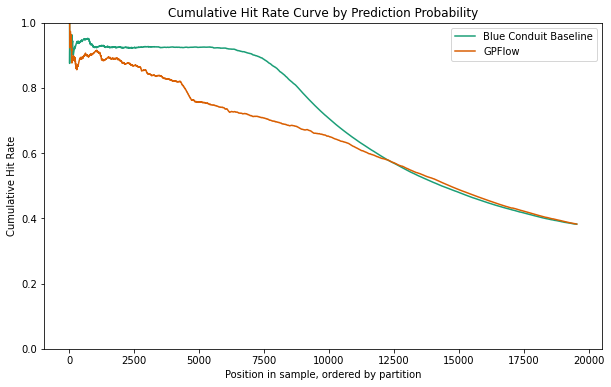

In [ ]:
# plot_hit_rate_curve_by_split_num(split_num=2)

In [ ]:
lonlatXtrain = pid[['Longitude', 'Latitude']].values[train_index]
lonlatXtest = pid[['Longitude', 'Latitude']].values[test_index]

X_train_spatiotemporal = np.hstack([Xtrain['Year Built'].values.reshape(-1, 1), lonlatXtrain[:,0].reshape(-1, 1), lonlatXtrain[:,1].reshape(-1, 1)])
X_test_spatiotemporal = np.hstack([Xtest['Year Built'].values.reshape(-1, 1), lonlatXtest[:,0].reshape(-1, 1), lonlatXtest[:,1].reshape(-1, 1)])


In [ ]:
(test_xtrain, test_ytrain), _, _, _, _, _ = GP_data[0.1][47][0]

kernel = gpflow.kernels.Matern12(variance=10, lengthscales=[3e-1, 3e-1])
likelihood = likelihood=gpflow.likelihoods.Bernoulli() 
test_vgp_model = gpflow.models.VGP((test_xtrain, test_ytrain), kernel, likelihood)

# optimizer.minimize(
#     test_vgp_model.training_loss, test_vgp_model.trainable_variables, options=dict(maxiter=ci_niter(100))
# )


      fun: 2508.813080369944
 hess_inv: <22596005x22596005 LbfgsInvHessProduct with dtype=float64>
      jac: array([13.74455147, -0.80238131, -0.68261728, ...,  3.66840534,
       -1.55663602, -0.54326538])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 114
      nit: 100
   status: 1
  success: False
        x: array([0.37423256, 0.32417414, 0.16492815, ..., 3.86163316, 4.98053309,
       7.23029709])